LabelEncoder for the target was done!

Preprocessing was done for clean text removing punctuation stopwords!

TF-IDF Vectorization was done to convert cleaned text into numerical features for model input.!
                                                                  
I used Multinomial Naive Bayes, which works well with text data and tested logistic regression.

Evaluation using accuracy, confusion matrix and a classification report, which provides precision, recall, and F1-score for both positive and negative classes.

Used only the 'content' and 'is_positive' for X and Y dataset respectively


In [1]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install joblib
!pip install wordcloud

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
def random_seed(SEED):
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)

SEED = 1921
random_seed(SEED)

if not os.path.exists('models'):
  os.makedir('models')

In [13]:
df = pd.read_csv("output.csv")
# Load the additional data
additional_data = pd.read_csv('output_steamspy.csv')  # Replace with your actual file path

Sample Data

In [15]:
# Convert 'content' column to string explicitly
df['content'] = df['content'].astype(str)
df = df.dropna()

# Total size of dataset
n = len(df)
N = list(range(n))
random.shuffle(N)
sampled_data = df.iloc[N[0:100000]] # Set the dataset size
sampled_data = sampled_data.reset_index(drop=True)

# verify the new shape
print("Original shape:", df.shape)
print("Sampled shape:", sampled_data.shape)

# verify the class distribution is maintained
print("\nOriginal class distribution:")
print(df['is_positive'].value_counts(normalize=True))
print("\nSampled class distribution:")
print(sampled_data['is_positive'].value_counts(normalize=True))

Original shape: (201151, 5)
Sampled shape: (100000, 5)

Original class distribution:
is_positive
Positive    0.510363
Negative    0.489637
Name: proportion, dtype: float64

Sampled class distribution:
is_positive
Positive    0.50922
Negative    0.49078
Name: proportion, dtype: float64


# Text Preprocessing

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import string
import re

In [17]:
#text preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip()
    return text

## Data Exploration

In [18]:
# Apply preprocessing to the content column
sampled_data['cleaned_content'] = sampled_data['content'].apply(preprocess_text)
sampled_data[50:60]

,id,app_id,content,author_id,is_positive,cleaned_content
50,179751722,620,awesome,76561199182634526,Positive,awesome
51,11537204,70,Batman's police friend is a scientist.,76561198016934636,Negative,batmans police friend is a scientist
52,181808393,620,Great game with unique portal mechanics,76561198869041299,Positive,great game with unique portal mechanics
53,132316290,280,why does this exist,76561198375885194,Negative,why does this exist
54,163641920,620,my game crashes every 3 sec when i open it up,76561198843643935,Negative,my game crashes every 3 sec when i open it up
55,171499311,730,lagging!!!!!,76561198930971479,Negative,lagging
56,17849018,130,A great story about everyone's favorite charac...,76561198054238987,Positive,a great story about everyones favorite charact...
57,177413158,730,good anticheat,76561199620333704,Negative,good anticheat
58,146272328,240,Its as good as it was 10 years ago,76561198305280006,Positive,its as good as it was 10 years ago
59,164206662,10,where are the updates,76561199007319497,Positive,where are the updates


### Word Count Analysis ###


<ipython-input-19-65fde63dbc42>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_positive', y='word_count', data=sampled_data, palette=sns_palette)
<ipython-input-19-65fde63dbc42>:7: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.boxplot(x='is_positive', y='word_count', data=sampled_data, palette=sns_palette)


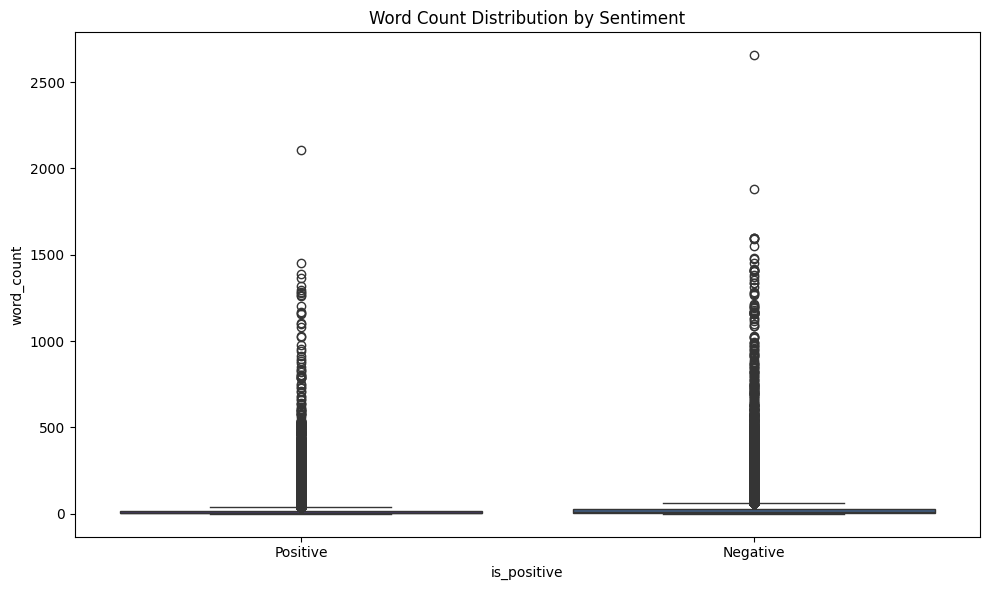

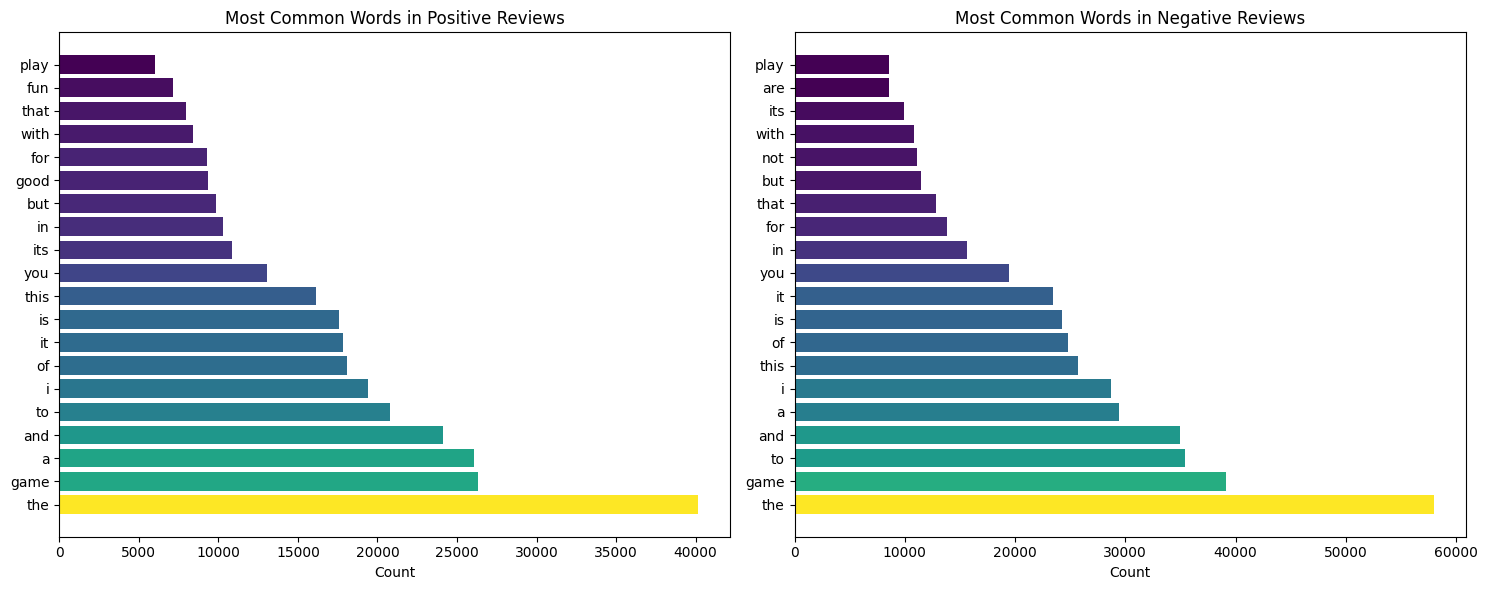


### Text Length Statistics ###

Positive Reviews:
count    50922.000000
mean        20.195947
std         53.622792
min          0.000000
25%          2.000000
50%          6.000000
75%         17.000000
max       2105.000000
Name: word_count, dtype: float64

Negative Reviews:
count    49078.000000
mean        30.037288
std         76.515057
min          0.000000
25%          3.000000
50%          9.000000
75%         26.000000
max       2656.000000
Name: word_count, dtype: float64


<ipython-input-19-65fde63dbc42>:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_positive', y='unique_words', data=sampled_data, palette=sns_palette)
<ipython-input-19-65fde63dbc42>:69: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.boxplot(x='is_positive', y='unique_words', data=sampled_data, palette=sns_palette)


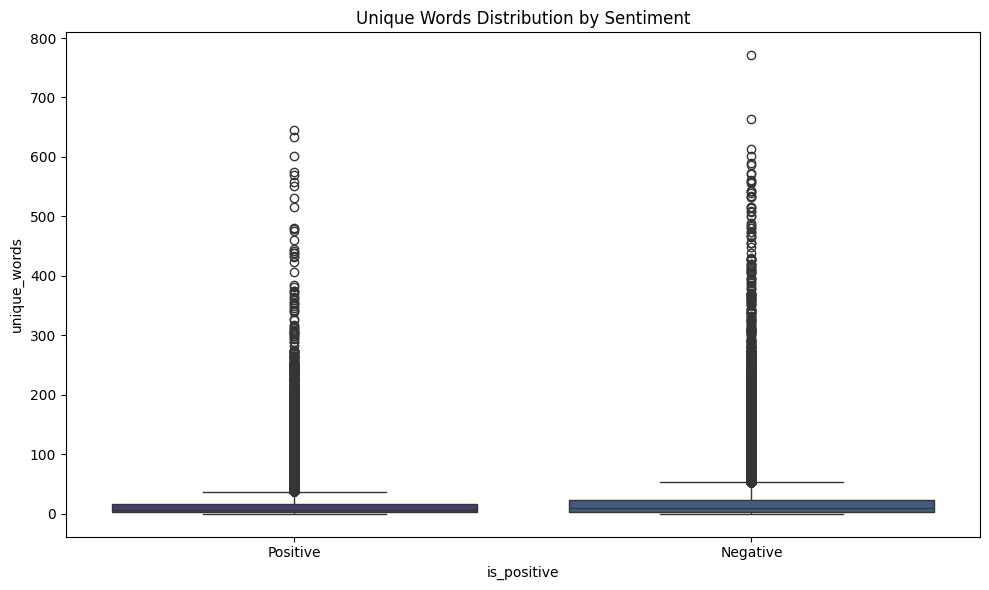

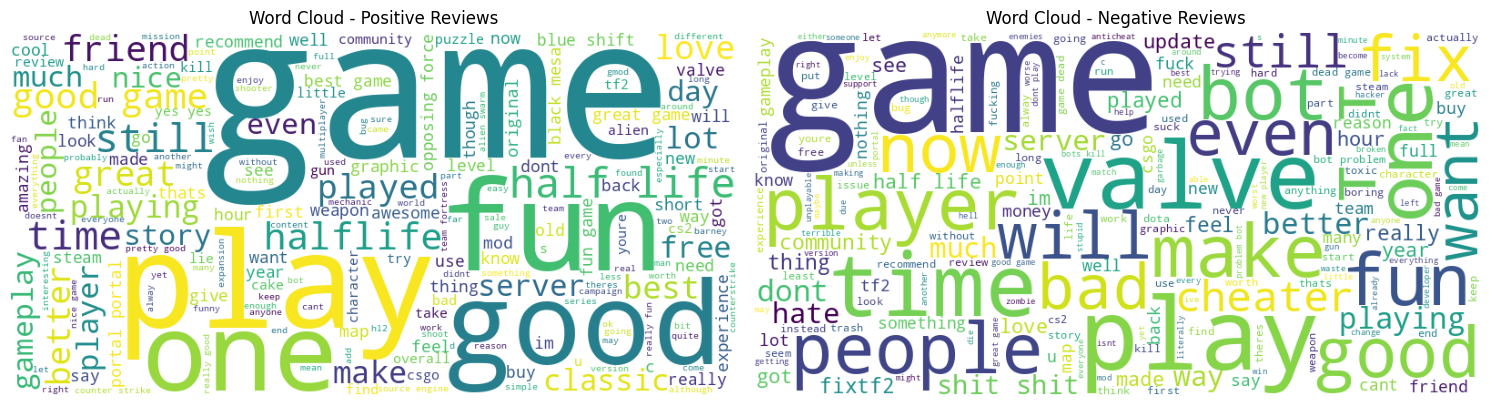

In [19]:
sns_palette = sns.color_palette('viridis')
# 1. Word Count Analysis
print("### Word Count Analysis ###")
sampled_data['word_count'] = sampled_data['cleaned_content'].str.split().str.len()

plt.figure(figsize=(10, 6))
sns.boxplot(x='is_positive', y='word_count', data=sampled_data, palette=sns_palette)
plt.title('Word Count Distribution by Sentiment')
plt.tight_layout()
plt.savefig('models/word_count_distribution.png', dpi=300)
plt.show()

import matplotlib.pyplot as plt
import numpy as np

# Your existing function to get most common words
from collections import Counter
import itertools

def get_most_common_words(texts, n=20):
    words = list(itertools.chain(*[text.split() for text in texts]))
    return Counter(words).most_common(n)

# Separating positive and negative reviews
positive_reviews = sampled_data[sampled_data['is_positive'] == 'Positive']['cleaned_content']
negative_reviews = sampled_data[sampled_data['is_positive'] == 'Negative']['cleaned_content']

# Getting most common words for each sentiment
pos_common_words = get_most_common_words(positive_reviews)
neg_common_words = get_most_common_words(negative_reviews)

# Plotting most common words
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Positive reviews
words, counts = zip(*pos_common_words)
norm = plt.Normalize(min(counts), max(counts))  # Normalize counts for color scaling
colors = plt.cm.viridis(norm(counts))  # Apply viridis colormap
ax1.barh(words, counts, color=colors)
ax1.set_title('Most Common Words in Positive Reviews')
ax1.set_xlabel('Count')

# Negative reviews
words, counts = zip(*neg_common_words)
norm = plt.Normalize(min(counts), max(counts))  # Normalize counts for color scaling
colors = plt.cm.viridis(norm(counts))  # Apply viridis colormap
ax2.barh(words, counts, color=colors)
ax2.set_title('Most Common Words in Negative Reviews')
ax2.set_xlabel('Count')

plt.tight_layout()
plt.savefig('models/common_words.png', dpi=300)
plt.show()

# 3. Text Length Statistics
print("\n### Text Length Statistics ###")
print("\nPositive Reviews:")
print(sampled_data[sampled_data['is_positive'] == 'Positive']['word_count'].describe())
print("\nNegative Reviews:")
print(sampled_data[sampled_data['is_positive'] == 'Negative']['word_count'].describe())

# 4. Unique Words Analysis
def count_unique_words(text):
    return len(set(text.split()))

sampled_data['unique_words'] = sampled_data['cleaned_content'].apply(count_unique_words)

plt.figure(figsize=(10, 6))
sns.boxplot(x='is_positive', y='unique_words', data=sampled_data, palette=sns_palette)
plt.title('Unique Words Distribution by Sentiment')
plt.tight_layout()
plt.savefig('models/unique_words_distribution.png', dpi=300)
plt.show()

# 5. Word Cloud Visualization
from wordcloud import WordCloud

plt.figure(figsize=(15, 6))

# Positive reviews word cloud
plt.subplot(1, 2, 1)
positive_text = ' '.join(positive_reviews)
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.imshow(wordcloud_pos)
plt.title('Word Cloud - Positive Reviews')
plt.axis('off')

# Negative reviews word cloud
plt.subplot(1, 2, 2)
negative_text = ' '.join(negative_reviews)
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(negative_text)
plt.imshow(wordcloud_neg)
plt.title('Word Cloud - Negative Reviews')
plt.axis('off')

plt.tight_layout()
plt.savefig('models/wordcloud.png', dpi=300)
plt.show()

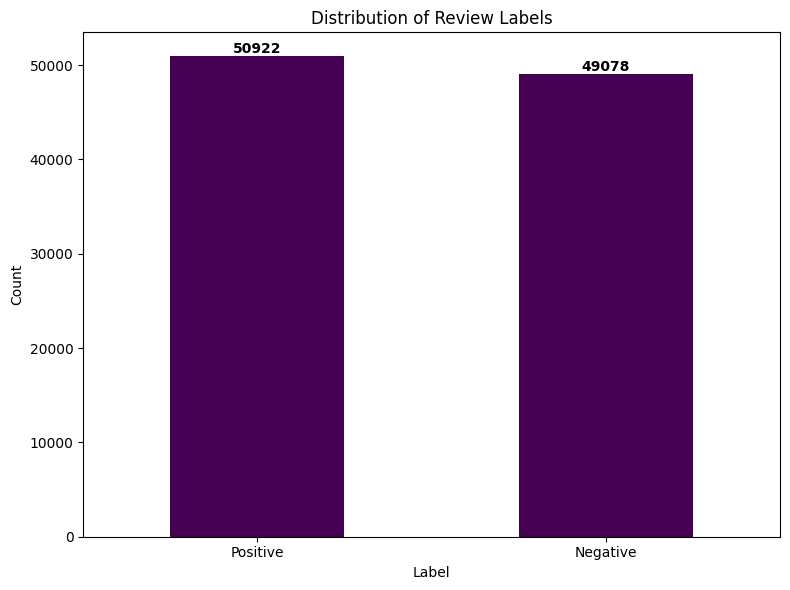

In [21]:
# create the bar plot
fig, ax = plt.subplots(figsize=(8, 6))
bars = sampled_data['is_positive'].value_counts().plot(kind='bar', colormap='viridis')
plt.title('Distribution of Review Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)

# add value annotations on top of each bar
for i, v in enumerate(sampled_data['is_positive'].value_counts()):
    ax.text(i, v, str(v),
            ha='center', va='bottom',
            fontweight='bold')

plt.tight_layout()
plt.savefig('models/distributions_labels.png', dpi=300)

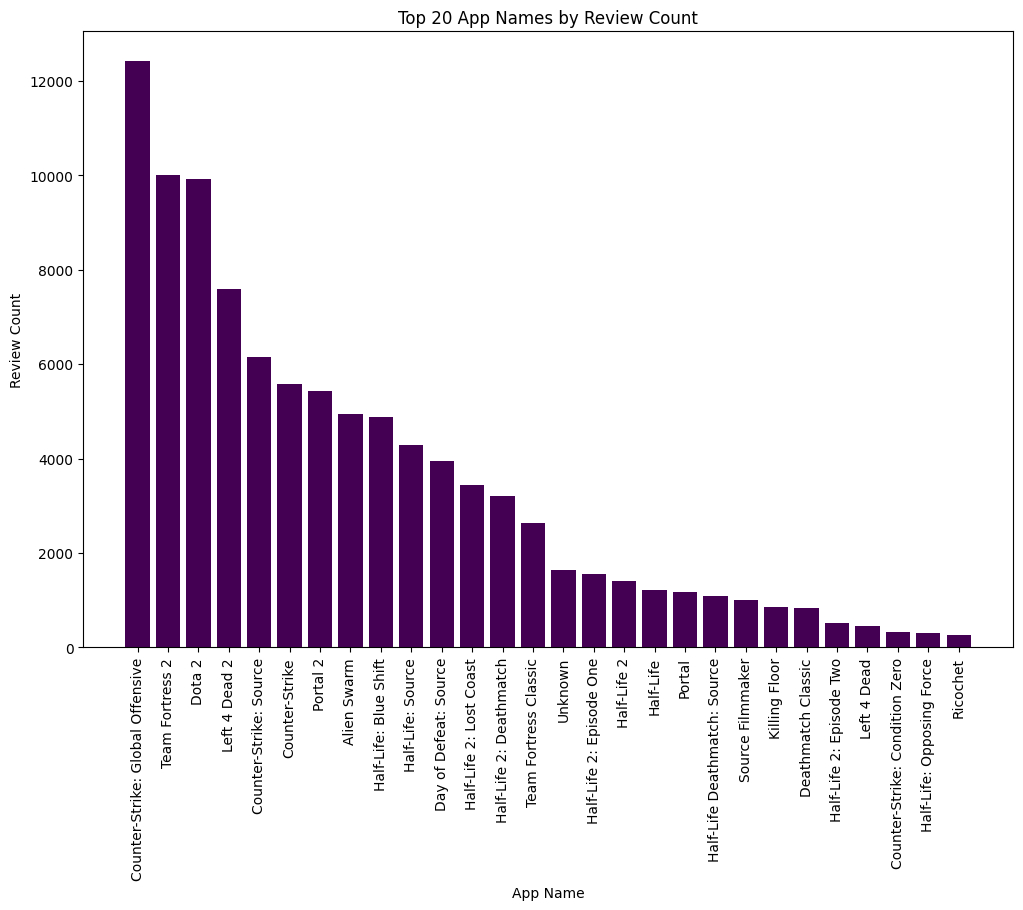

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Merge the DataFrames on 'app_id'
merged_df = sampled_data.merge(additional_data, left_on='app_id', right_on='appid')

# Get the top 20 app IDs by review count
top20_appid = sampled_data['app_id'].value_counts().head(50)

# Create a dictionary to map app_id to app name
app_id_to_name = dict(zip(additional_data['appid'], additional_data['name']))

# Get the names corresponding to the top 20 app IDs, handling missing keys
top20_names = [app_id_to_name.get(appid, 'Unknown') for appid in top20_appid.index]

# Plot the data
plt.figure(figsize=(12, 8))
plt.bar(top20_names, top20_appid.values, color=plt.cm.viridis_r(np.linspace(5, 1, 1)))
plt.xlabel('App Name')
plt.ylabel('Review Count')
plt.title('Top 20 App Names by Review Count')

plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.savefig("models/top20_reviewCount.png", dpi=300)
plt.show()

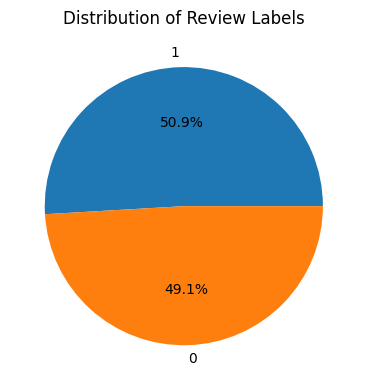

In [28]:
# pie Chart
plt.figure(figsize=(7, 4))
sampled_data['is_positive'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Review Labels')
plt.ylabel('')
plt.tight_layout()
plt.show()

## Encode Target Column

In [30]:
# Make label for target
label_encoder = LabelEncoder()
sampled_data['is_positive'] = label_encoder.fit_transform(sampled_data['is_positive'])

## Pipeline

In [31]:
# use to predict input
def pipeline(model, inputs: list, vectorizer):
    for text in inputs:
        preprocessed = preprocess_text(text)
        vectorized = vectorizer.transform([preprocessed])
        prediction = model.predict(vectorized)
        print(f"Input: {text}")
        if prediction[0] == 1:
            print("Output: Positive Sentiment")
        else:
            print("Output: Negative Sentiment")

## Display CLF report and CM

In [32]:
def plot_and_save_classification_report_and_confusion_matrix(y_true, y_pred, labels=None, path=None, report=None):
    # Ensure the path exists
    if not os.path.exists(path):
        os.makedirs(path)

    # Generate classification report
    report = classification_report(y_true, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()

    # Plot classification report
    plt.figure(figsize=(10, 6))
    sns.heatmap(report_df.iloc[:-1, :3].T, annot=True, cmap='viridis')
    plt.savefig(os.path.join(path, 'classification_report.png'), dpi=300)  # Save the classification report figure
    plt.show()

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='viridis')
    plt.savefig(os.path.join(path, 'confusion_matrix.png'), dpi=300)  # Save the confusion matrix figure
    plt.show()

## Save & Load Model Func

In [33]:
import joblib
import os

def save_model_and_vectorizer(model, vectorizer, path, model_filename='model.pkl', vectorizer_filename='vectorizer.pkl'):
    # Ensure the path exists
    if not os.path.exists(path):
        os.makedirs(path)

    # Save the model
    joblib.dump(model, os.path.join(path, model_filename))
    print(f"Model saved to {os.path.join(path, model_filename)}")

    # Save the vectorizer
    joblib.dump(vectorizer, os.path.join(path, vectorizer_filename))
    print(f"Vectorizer saved to {os.path.join(path, vectorizer_filename)}")

def load_model_and_vectorizer(path, model_filename='model.pkl', vectorizer_filename='vectorizer.pkl'):
    # Load the model
    model = joblib.load(os.path.join(path, model_filename))
    print(f"Model loaded from {os.path.join(path, model_filename)}")

    # Load the vectorizer
    vectorizer = joblib.load(os.path.join(path, vectorizer_filename))
    print(f"Vectorizer loaded from {os.path.join(path, vectorizer_filename)}")

    return model, vectorizer

## Evaluate Model

In [34]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, vectorizer_name, save_path=None):
    """
    Evaluate the given model, print accuracy, classification report,
    and save the classification report and confusion matrix figures.
    """
    # Fit the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Print model details
    print(f"\n{model_name} with {vectorizer_name}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Save path setup
    if save_path and not os.path.exists(save_path):
        os.makedirs(save_path)

    # Call the function to plot and save classification report and confusion matrix
    plot_and_save_classification_report_and_confusion_matrix(
        y_true=y_test,
        y_pred=y_pred,
        labels=model.classes_ if hasattr(model, 'classes_') else None,
        path=save_path
    )

## Model Dataset

In [35]:
# Split the dataset into training and test sets
X = sampled_data['cleaned_content']  # Features (cleaned text)
y = sampled_data['is_positive']      # Labels (sentiment)

In [36]:
# initializing the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# fitting the vectorizer on the cleaned content
X_tfidf = tfidf_vectorizer.fit_transform(X)

In [37]:
# displaying the shape of the TF-IDF matrix
X_tfidf.shape

(100000, 5000)

In [38]:
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2,
                                                                            random_state=42,
                                                                            stratify=y)

# displaying the shape of the training and testing sets
X_train_tfidf.shape, X_test_tfidf.shape, y_train.shape, y_test.shape

((80000, 5000), (20000, 5000), (80000,), (20000,))

## MultinomialNB


MultinomialNB with TF-IDF
Accuracy: 82.99%

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.79      0.82      9816
           1       0.81      0.87      0.84     10184

    accuracy                           0.83     20000
   macro avg       0.83      0.83      0.83     20000
weighted avg       0.83      0.83      0.83     20000



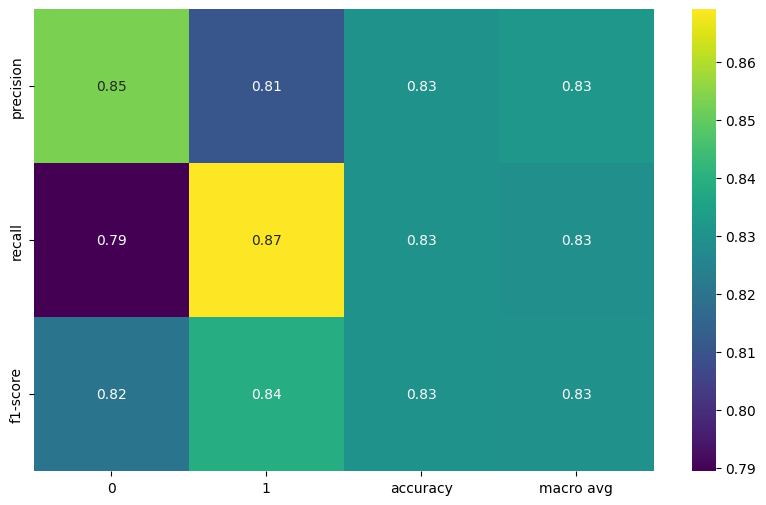

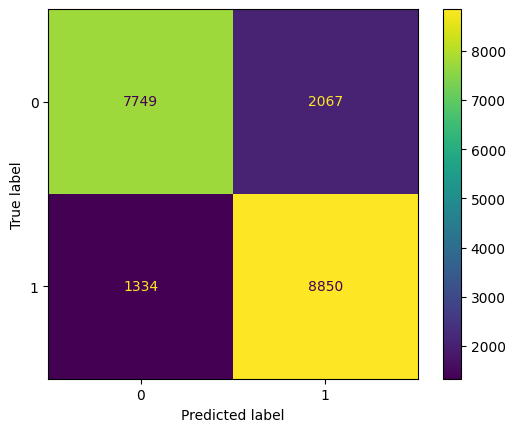

In [39]:
# Modeling
model_mnb = MultinomialNB()
save_path = 'models/mnb'

# Evaluate model
evaluate_model(
    model=model_mnb,
    X_train=X_train_tfidf,
    X_test=X_test_tfidf,
    y_train=y_train,
    y_test=y_test,
    model_name="MultinomialNB",
    vectorizer_name="TF-IDF",
    save_path=save_path
)

In [40]:
save_model_and_vectorizer(model_mnb, tfidf_vectorizer, path=save_path)

test_inputs = ["compare to the cs2 its good", "yeah. 1/10"]
test_model, vec = load_model_and_vectorizer(save_path)

pipeline(test_model, test_inputs, vectorizer=vec)

Model saved to models/mnb/model.pkl
Vectorizer saved to models/mnb/vectorizer.pkl
Model loaded from models/mnb/model.pkl
Vectorizer loaded from models/mnb/vectorizer.pkl
Input: compare to the cs2 its good
Output: Positive Sentiment
Input: yeah. 1/10
Output: Negative Sentiment


## Logistic Regression


Logistic Regression with TF-IDF
Accuracy: 84.06%

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.81      0.83      9816
           1       0.82      0.87      0.85     10184

    accuracy                           0.84     20000
   macro avg       0.84      0.84      0.84     20000
weighted avg       0.84      0.84      0.84     20000



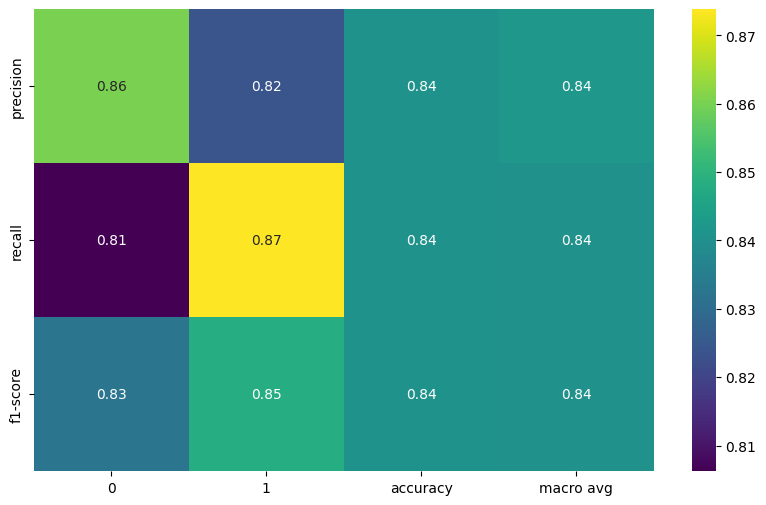

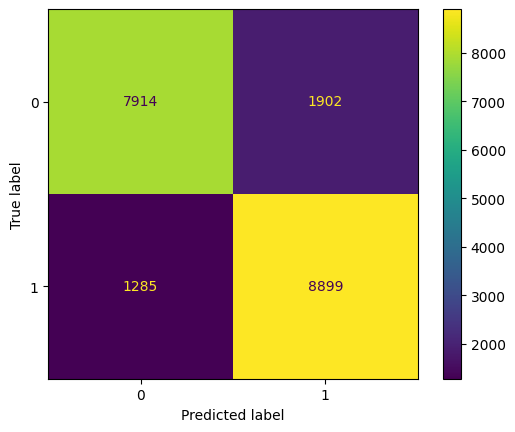

In [41]:
from sklearn.linear_model import LogisticRegression

# Train a Logistic Regression model
model_lr = LogisticRegression()

save_path = 'models/lr'

# Evaluate model
evaluate_model(
    model=model_lr,
    X_train=X_train_tfidf,
    X_test=X_test_tfidf,
    y_train=y_train,
    y_test=y_test,
    model_name="Logistic Regression",
    vectorizer_name="TF-IDF",
    save_path=save_path
)

In [42]:
save_model_and_vectorizer(model_lr, tfidf_vectorizer, path=save_path)

test_inputs = ["compare to the cs2 its good", "yeah. 1/10"]
test_model, vec = load_model_and_vectorizer(save_path)

pipeline(test_model, test_inputs, vectorizer=vec)

Model saved to models/lr/model.pkl
Vectorizer saved to models/lr/vectorizer.pkl
Model loaded from models/lr/model.pkl
Vectorizer loaded from models/lr/vectorizer.pkl
Input: compare to the cs2 its good
Output: Positive Sentiment
Input: yeah. 1/10
Output: Negative Sentiment


# 👇Ignore

## SVM


Support Vector Machine with TF-IDF
Accuracy: 84.16%

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.80      0.83      9816
           1       0.82      0.89      0.85     10184

    accuracy                           0.84     20000
   macro avg       0.84      0.84      0.84     20000
weighted avg       0.84      0.84      0.84     20000



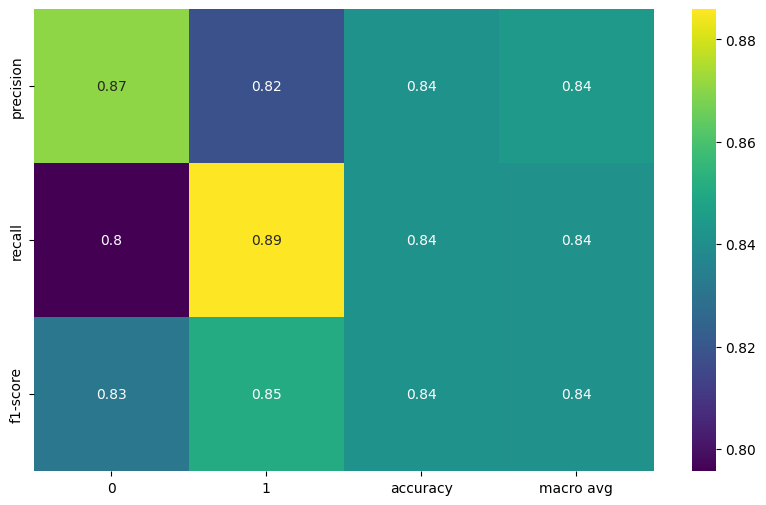

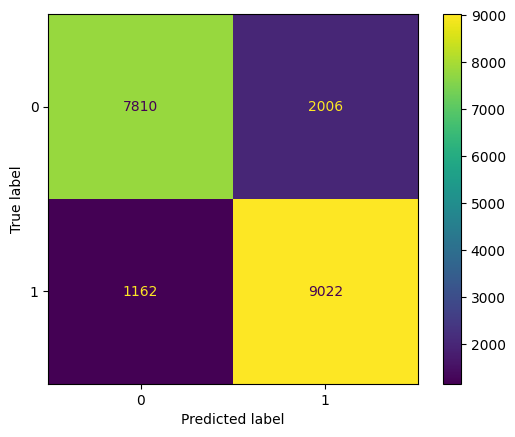

In [43]:
from sklearn.svm import SVC

# Train a SVM  model
model_svm = SVC(kernel='linear', random_state=42)

save_path = 'models/svm'

# Evaluate model
evaluate_model(
    model=model_svm,
    X_train=X_train_tfidf,
    X_test=X_test_tfidf,
    y_train=y_train,
    y_test=y_test,
    model_name="Support Vector Machine",
    vectorizer_name="TF-IDF",
    save_path=save_path
)

In [45]:
save_model_and_vectorizer(model_svm, tfidf_vectorizer, path=save_path)

test_inputs = ["compare to the cs2 its good", "yeah. 1/10"]
test_model, vec = load_model_and_vectorizer(save_path)

pipeline(test_model, test_inputs, vectorizer=vec)

Model saved to models/svm/model.pkl
Vectorizer saved to models/svm/vectorizer.pkl
Model loaded from models/svm/model.pkl
Vectorizer loaded from models/svm/vectorizer.pkl
Input: compare to the cs2 its good
Output: Positive Sentiment
Input: yeah. 1/10
Output: Negative Sentiment


## Random Forest


Random Forest with TF-IDF
Accuracy: 83.00%

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.81      0.82      9816
           1       0.82      0.85      0.84     10184

    accuracy                           0.83     20000
   macro avg       0.83      0.83      0.83     20000
weighted avg       0.83      0.83      0.83     20000



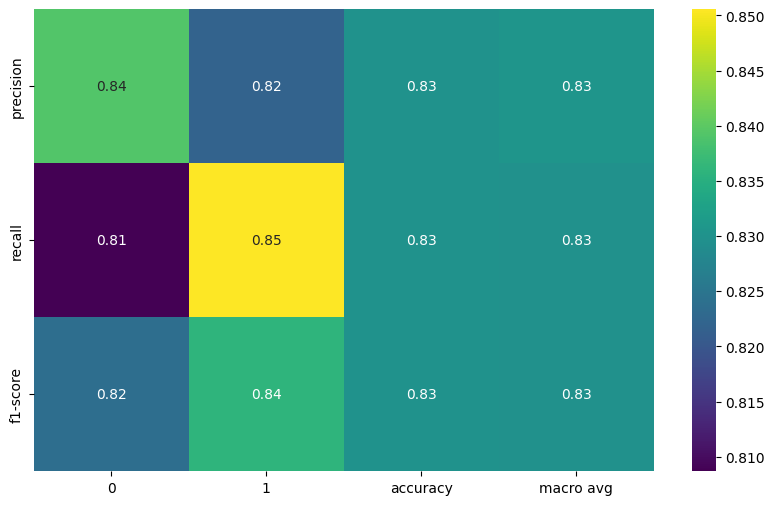

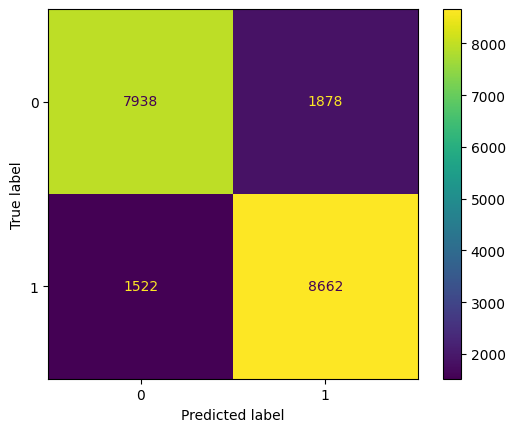

In [46]:
from sklearn.ensemble import RandomForestClassifier
# Create a Random Forest classifier
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
save_path = 'models/rf'

# Evaluate model
evaluate_model(
    model=model_rf,
    X_train=X_train_tfidf,
    X_test=X_test_tfidf,
    y_train=y_train,
    y_test=y_test,
    model_name="Random Forest",
    vectorizer_name="TF-IDF",
    save_path=save_path
)

In [47]:
save_model_and_vectorizer(model_rf, tfidf_vectorizer, path=save_path)

test_inputs = ["compare to the cs2 its good", "yeah. 1/10"]
test_model, vec = load_model_and_vectorizer(save_path)

pipeline(test_model, test_inputs, vectorizer=vec)

Model saved to models/rf/model.pkl
Vectorizer saved to models/rf/vectorizer.pkl
Model loaded from models/rf/model.pkl
Vectorizer loaded from models/rf/vectorizer.pkl
Input: compare to the cs2 its good
Output: Positive Sentiment
Input: yeah. 1/10
Output: Positive Sentiment


# Model Comparison

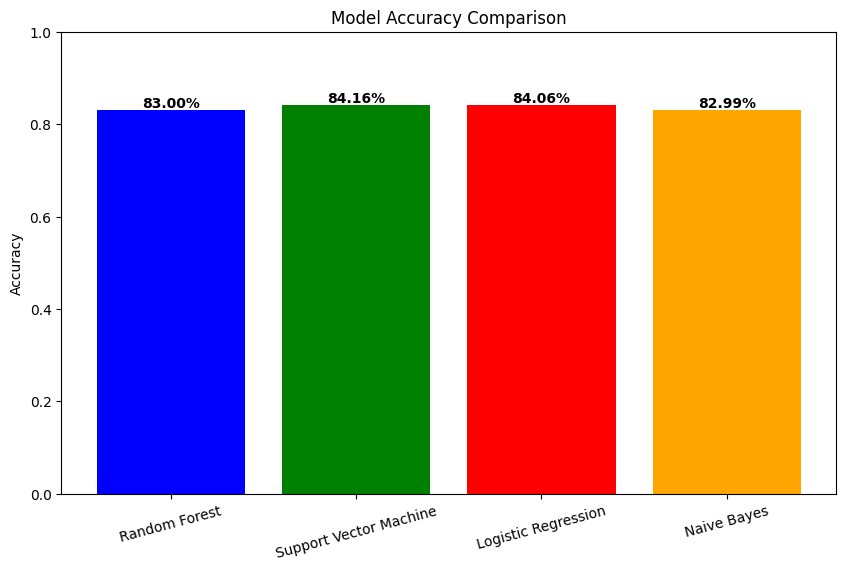

In [50]:
# Bar chart for model comparison
fig, ax = plt.subplots(figsize=(10, 6))

# Accuracy scores for each model
accuracies = [
    accuracy_score(y_test, model_rf.predict(X_test_tfidf)),
    accuracy_score(y_test, model_svm.predict(X_test_tfidf)),
    accuracy_score(y_test, model_lr.predict(X_test_tfidf)),
    accuracy_score(y_test, model_mnb.predict(X_test_tfidf))
]
models = ['Random Forest', 'Support Vector Machine', 'Logistic Regression', 'Naive Bayes']

# Adding annotations to the bars
for i, v in enumerate(accuracies):
    ax.text(i, v, f"{v*100:.2f}%",
            ha='center', va='bottom',
            fontweight='bold')

# Plotting the accuracy scores
ax.bar(models, accuracies, color=['blue', 'green', 'red', 'orange'])

# Customizing the plot
ax.set_title('Model Accuracy Comparison')
ax.set_ylabel('Accuracy')
ax.set_ylim(0, 1)  # Scale from 0 to 1 for accuracy
plt.xticks(rotation=15)

# Save the plot to a file
plt.savefig('models/model_accuracy_comparison.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

<ipython-input-55-076231a994c4>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='importance', y='feature', palette=sns.color_palette("viridis", n_features)


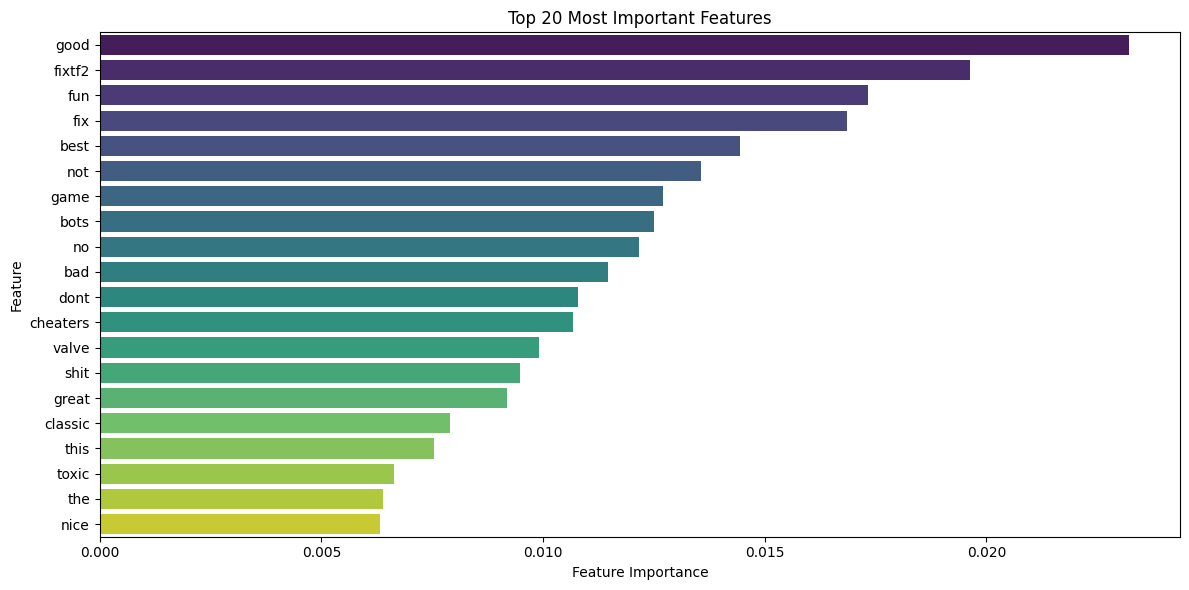


Top feature importance scores:
good: 0.0232
fixtf2: 0.0196
fun: 0.0173
fix: 0.0169
best: 0.0144
not: 0.0136
game: 0.0127
bots: 0.0125
no: 0.0122
bad: 0.0115
dont: 0.0108
cheaters: 0.0107
valve: 0.0099
shit: 0.0095
great: 0.0092
classic: 0.0079
this: 0.0075
toxic: 0.0066
the: 0.0064
nice: 0.0063


In [55]:
def visualize_feature_importance(rf_model, vectorizer, n_features=20):

    # get feature names and importance scores
    feature_names = vectorizer.get_feature_names_out()
    importances = rf_model.feature_importances_

    # create a dataframe of features and their importance scores
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    })

    # sort by importance and get top n_features
    top_features = feature_importance.sort_values('importance', ascending=False).head(n_features)

    # create the visualization
    plt.figure(figsize=(12, 6))
    sns.barplot(data=top_features, x='importance', y='feature', palette=sns.color_palette("viridis", n_features)
)
    plt.title(f'Top {n_features} Most Important Features')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.savefig('models/feature_importance.png', dpi=300)
    plt.show()

    # print the numerical values
    print("\nTop feature importance scores:")
    for idx, row in top_features.iterrows():
        print(f"{row['feature']}: {row['importance']:.4f}")

visualize_feature_importance(model_rf, tfidf_vectorizer)

# Save the Local Folder (COLAB)

In [56]:
# Zip the folder
!zip -r /content/models.zip /content/models

# Download the zip file
from google.colab import files
files.download('/content/models.zip')

updating: content/models/ (stored 0%)
updating: content/models/top20_reviewCount.png (deflated 24%)
updating: content/models/unique_words_distribution.png (deflated 26%)
updating: content/models/distributions_labels.png (deflated 34%)
updating: content/models/word_count_distribution.png (deflated 28%)
updating: content/models/mnb/ (stored 0%)
updating: content/models/mnb/vectorizer.pkl (deflated 70%)
updating: content/models/mnb/model.pkl (deflated 6%)
updating: content/models/mnb/classification_report.png (deflated 24%)
updating: content/models/mnb/confusion_matrix.png (deflated 24%)
updating: content/models/common_words.png (deflated 32%)
updating: content/models/svm/ (stored 0%)
updating: content/models/svm/vectorizer.pkl (deflated 70%)
updating: content/models/svm/model.pkl (deflated 34%)
updating: content/models/svm/classification_report.png (deflated 26%)
updating: content/models/svm/confusion_matrix.png (deflated 24%)
updating: content/models/rf/ (stored 0%)
updating: content/mo

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>